In [ ]:
!pip install pandas numpy matplotlib yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
import contextlib
import sys, os
import warnings
warnings.filterwarnings('ignore')


@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


In [ ]:
import yfinance as yf

def download_data(ticker, start_date, end_date):
    """
    a function for downloading data
    goal is to clean and pre process data before any implementaion
    of any stratergy.
    """
    data = yf.download(ticker, start=start_date, end=end_date)

    # setting index
    data['Date'] = data.index

    # a error is goiing in new y finance library version with adj close
    if 'Adj Close' not in data.columns:
        data['Adj Close'] = data['Close']

    # final sahpe of data
    return data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]


In [ ]:
def EMA_RSI_strat(data):
    """
    Strategy: Buy when short EMA crosses above long EMA AND RSI is below 70 (not overbought).
    Sell when short EMA crosses below long EMA OR RSI is above 70.
    """
    import pandas as pd

    # Calculate indicators
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()

    # RSI Calculation
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Buy when EMA12 > EMA26 and RSI < 70 (uptrend, not overbought)
    # Sell otherwise (or hold cash)
    data['signal'] = 0
    data.loc[(data['EMA_12'] > data['EMA_26']) & (data['RSI'] < 70), 'signal'] = 1

    return data


In [ ]:
def backtest(data, initial_capital=100000.0):
    data = data.copy()
    data['position'] = data['signal']
    data['daily_return'] = data['Adj Close'].pct_change()
    data['strategy_return'] = data['position'].shift(1) * data['daily_return']
    data['portfolio_value'] = (1 + data['strategy_return']).cumprod() * initial_capital
    return data

In [ ]:
def generate_report(data, initial_capital):
    final_value = data['portfolio_value'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100
    max_drawdown = ((data['portfolio_value'].cummax() - data['portfolio_value']) / data['portfolio_value'].cummax()).max() * 100

    print(f"Initial Capital: ${initial_capital:,.2f}")
    print(f"Final Portfolio Value: ${final_value:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data['portfolio_value'], label='Portfolio Value', linewidth=2)
    plt.title('Strategy Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Initial Capital: $100,000.00
Final Portfolio Value: $102,426.49
Total Return: 2.43%
Max Drawdown: 28.42%


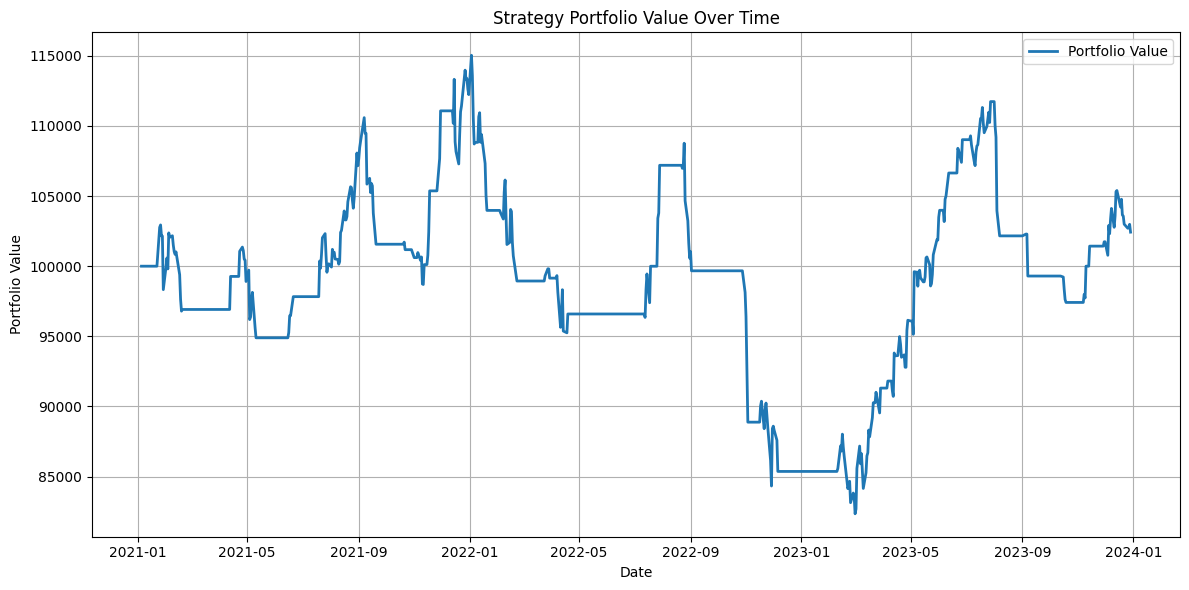

In [ ]:
# final assembly
with suppress_output():
    data = download_data('AAPL', '2021-01-01', '2024-01-01')
    data = EMA_RSI_strat(data)
    portfolio = backtest(data, initial_capital=100000.0)

# for data insights
generate_report(portfolio, 100000.0)
